# Introduction into handling geographical data

In [9]:
from nbindex import floating
floating.tableofcontent()

[John Snow](https://en.wikipedia.org/wiki/John_Snow) was an English physician, who was first to trace the source of a cholera outbreak in London's Soho district in 1854 using data visualization. In the following exercises, we are going to reconstruct the map of Snow with modern tools and explore some ideas of geographic data analysis.

<img src="https://upload.wikimedia.org/wikipedia/commons/2/27/Snow-cholera-map-1.jpg" width="400px"></img>

Though there is a whole [R library](https://vincentarelbundock.github.io/Rdatasets/doc/HistData/Snow.pumps.html) dedicated to this dataset, we would like R users to also build the solutions (e.g. Voronoi cells) from scratch.

Further reading:
* https://en.wikipedia.org/wiki/1854_Broad_Street_cholera_outbreak
* https://www1.udel.edu/johnmack/frec682/cholera/cholera2.html
* https://www.theguardian.com/news/datablog/interactive/2013/mar/15/cholera-map-john-snow-recreated

The shapefile that will be used in these exercises are located at http://donboyes.com/2011/10/14/john-snow-and-serendipity/, but they are already downloaded into the shapes directory.

In [10]:
import glob

import geopandas as gp
from pyproj import CRS
import shapely

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy, copy

matplotlib.rcParams["axes.titlesize"] = 16
matplotlib.rcParams["axes.labelsize"] = 13

matplotlib.rcParams["xtick.labelsize"] = 16
matplotlib.rcParams["ytick.labelsize"] = 16
matplotlib.rcParams["axes.grid"] = True
matplotlib.rcParams["xtick.major.size"] = 12
matplotlib.rcParams["ytick.major.size"] = 12
matplotlib.rcParams["xtick.major.width"] = 2
matplotlib.rcParams["ytick.major.width"] = 2

## Exercise 1

Load the death and the pump dataset into a tabular format! Have a look at the dataset's structure! The pump dataset contains the locations of wells, that were used to obtain water for drinking, cooking etc.

*The format of the files is called [shapefile](https://en.wikipedia.org/wiki/Shapefile), which is a format that is easily readable by the most common GIS (Geographic Information System) softwares. Shapefiles consist of many files, some of which store the geographic information, some the coordinate system description, some the additional attributes of the geographical objects. [geopandas](http://geopandas.org/) is able to read shapefiles natively into its base class GeoDataFrame, which has a similar API to that of `pandas` `DataFrames`. This is convenient, because we can use all of our previous knowledge of `pandas`.*

*It is sometimes worth to have a look at a shapefile's content quickly. For Linux, [QGIS](https://www.qgis.org/en/site/about/index.html) is a powerful free GIS system, try it at home!*

In [11]:
death_files = glob.glob("/home/course/Datasets/data-johnsnowmap/shapes/deaths_gcs.*")
pump_files = glob.glob("/home/course/Datasets/data-johnsnowmap/shapes/pumps*.*")

In [12]:
death_data = gp.read_file('/home/course/Datasets/data-johnsnowmap/shapes/deaths_gcs.shp' )
death_data = death_data.drop(columns="OBJECTID")

pump_data = gp.read_file( '/home/course/Datasets/data-johnsnowmap/shapes/pumps_gcs.shp')
pump_data = pump_data.drop(columns ="OBJECTID")

OSError: no such file or directory: '/home/course/Datasets/data-johnsnowmap/shapes/deaths_gcs.shp'

## Exercise 2

Extract the latitudes and the longitudes for each row in both datasets as additional columns!

*In a `GeoDataFrame`, the `geometry` column contains geometry objects from the [`shapely`](https://toblerity.org/shapely/index.html) library. These objects have coordinate attributes, that is where latitude and longitude values are stored.*

The 'X' and 'Y' columns are coordinates in an arbitrary coordinate system and usually not part of a *shp* file. 

Project your points into a coordinate system where you can measure real distances (using e.g. `pyproj`), then create a meaningul visualization of the data!

*It is crucial to use the appropriate coordinate system for your purposes. For this exercise, the spherical coordinate system of lon, lat values is not convenient, since we cannot calculate distances in meters as easily as we would in a Cartesian coordinate system. Because of the Earth's shape, most projections distort distances at certain latitudes and longitudes.*

*In GIS, different coordinate systems are called CRS (Coordinate Reference System), and have patented codes that define the origin, the projection etc. The usual lon, lat pairs are called the WGS84 system (you will need to find its epsg code first). A good choice for a Cartesian system is for example the Pseudo-Mercator projection. The `pyproj` library is especially lightweight to use in Python.*

In [ ]:
pump_data.crs, pump_data.crs #This is really the WGS84 system

In [ ]:
pump_data.plot()

The [Pseudo-Mercator](https://epsg.io/3857) projection's EPSG code is 3857. The coordinates here are the horizontal and vertical projections of distance in meters from the [Null Island](https://en.wikipedia.org/wiki/Null_Island), where equator and prime meridian meet.

In [ ]:
pump_data.to_crs({'init': 'epsg:3857'}, inplace=True)
death_data.to_crs({'init': 'epsg:3857'}, inplace=True)
pump_data.plot()

In [ ]:
pump_data

In [ ]:
pump_data["X"] = pump_data.geometry.x
pump_data["Y"] = pump_data.geometry.y
death_data["X"] = death_data.geometry.x
death_data["Y"] = death_data.geometry.y

In [ ]:
pump_data.head(), death_data.head()

In [ ]:
plt.figure(figsize=[9,6])

plt.scatter(death_data.X,death_data.Y, color="tab:red", label="deaths")
plt.scatter(pump_data.X,pump_data.Y,color="tab:purple",label="pumps")
plt.legend()

On the graph above we can see that the contamination is somewhat bounded to a small location. More importantly, there is a connection between deaths and which pump is the closest to a point.

## Exercise 3

How many deaths were within a given radius around the wells? Test for a series of radiuses. 

### Union of pump areas

In [ ]:
def deaths_around_wells(distance, plot = True):
    '''Find the deaths within a radius around the wells'''
    pump_polygons = pump_data.geometry.buffer(distance).unary_union #union of the areas of the given radius of all wells 
    is_death_data_within = death_data.geometry.within(pump_polygons) #check if point is in the union of areas
    filtered_death = death_data[ is_death_data_within ] #mask points based on withinness
    
    if plot == True:
    #Plot
        plt.figure(figsize=[8,5])

        plt.scatter(death_data.X,death_data.Y, color="tab:red", label="deaths")

        plt.scatter(filtered_death.geometry.x, filtered_death.geometry.y, color="tab:orange", 
                 label= f"deaths in radius {distance} m: {len(filtered_death)}")
        plt.scatter(pump_data.X,pump_data.Y,color="tab:purple",label="pumps",s = 100)
        plt.legend(fontsize=12)
    else:
        return len(filtered_death)


In [ ]:
for radius in [30, 100, 150, 200]:
    deaths_around_wells(radius)

It can be inferred, that as the radii grows the number of deaths also increases.

In [ ]:
t = np.arange(0,300,10)
plt.figure(figsize=[8,6])
plt.plot(t,[deaths_around_wells(t1,plot=False) for t1 in t],color="tab:blue")
plt.xlabel("radii from the pumps [m]")
plt.ylabel("sum of the number of deads")
plt.title("All pumps")

### Individual pumps

In [ ]:
def deaths_around_1well(distance, well_no):
    pump_polygon = pump_data.iloc[well_no].geometry.buffer(distance)

    return sum(death_data.geometry.within(pump_polygon))

In [ ]:
plt.figure(figsize=[9,6])
plt.scatter(pump_data.X,pump_data.Y,s=250,color="tab:purple", label="pumps")
for idx in pump_data.index:
    plt.text(pump_data.iloc[idx].X, pump_data.iloc[idx].Y, str(idx), color="white", weight ="bold",
            ha = "center", va="center",)
plt.scatter(death_data.X,death_data.Y, color="tab:red", label="deaths")
plt.legend()

In [ ]:
tt = np.arange(0,300,20)
plt.figure(figsize=[16,16])
for idx in pump_data.index:
    plt.subplot(5,3,idx+1)
    plt.plot(tt, [deaths_around_1well(t2, idx) for t2 in tt])
    plt.title(f"Pump no. {idx}")
plt.tight_layout()

With the help of the graphs above, we can further conclude that the relationship between the contamination and certain pumps shines through: the main source of the epidemic is pump 6, and it spread even more in the area of pump 7,8,9.

## Exercise 4

Put both the deaths and the pumps on a zoomable map that has a base layer from a tile server different from that of the default settings of your chosen method. Set the appropriate map center and zoom level. Use different markers for the deaths and the pumps datasets.

*Try folium in Python, or Leaflet in R or JS. Display the map here in the notebook.*

In [ ]:
import json, folium

#Reprojecting coordinates, creating Folium map object

latlon_pump = pump_data.to_crs({'init':'epsg:4326'}) #reprojecting coordinates
latlon_death = death_data.to_crs({'init':'epsg:4326'})
mymap = folium.Map(location=[51.513,-0.135], zoom_start=15.5,tiles='cartodbpositron')


#Putting markers on the locations of the pumps and the place of death

def addDeathMarker(fmap):
    for idx, lon, lat in zip(latlon_death.index, latlon_death.geometry.x, latlon_death.geometry.y):

        folium.Marker(
            location = [lat, lon], 
            tooltip = "deaths", #mouseover text
            icon = folium.Icon(color="red",icon="times", prefix="fa"), #style of the icon
            
            ).add_to(fmap)
    return fmap
    
def addPumpMarker(fmap):
    for idx, lon, lat in zip(latlon_pump.index, latlon_pump.geometry.x, latlon_pump.geometry.y):

        folium.Marker(
            location = [lat, lon],
            tooltip = f"well no. {idx}",
            icon = folium.Icon(color="purple", icon="tint", prefix = "fa"),
            
            ).add_to(fmap)
    return fmap


mymap = addDeathMarker(mymap)
mymap = addPumpMarker(mymap)
mymap



## Exercise 5

Calculate the Voronoi cells for the pumps, and count the number of deaths falling into each of the cells.  Create a bar chart of the number of deaths in each cell. Pinpoint the possible source of the infection.

*Store the Voronoi cells in a GeoDataFrame, then you can easily do a spatial join (e.g. testing whether a polygon in the Voronoi dataframe contains a point from the death dataframe).*

In [19]:
import pytess

mymap3 = folium.Map(location=[51.513,-0.135], zoom_start=15.3,tiles='cartodbpositron')
mymap3 = addPumpMarker(mymap3)
mymap3 = addDeathMarker(mymap3)

voronoipolys = pytess.voronoi(pump_data[["X","Y"]].to_numpy())

mp = [shapely.geometry.Polygon(v[1]) for v in voronoipolys]

In [20]:
#Get rid of Voronoi cells, that has no wells in it

valid_mps_index = [True if pump_data.geometry.within( p ).sum() > 0 else False for p in mp]
valid_mps = np.array(mp)[valid_mps_index]
reindexed = [ [ i for i, x in enumerate( pump_data.geometry.within( p ) ) if x] for p in valid_mps]

#Reshuffling cells
ordered_mps = [x for _,x in sorted(zip(reindexed,valid_mps))]

In [21]:
count_by_cell = [death_data.geometry.within( p ).sum() for p in ordered_mps]
count_by_cell

[0, 1, 13, 23, 6, 60, 349, 16, 32, 71, 1, 2, 4]

In [22]:
shp_vpoly = gp.GeoDataFrame(ordered_mps, crs={"init":"EPSG:3857"}, columns = ["geometry"]).to_crs({'init':'epsg:4326'})
#r_geojson3 = json.loads(shp_vpoly.to_json())

geojsons3 = [ json.loads(gp.GeoDataFrame(shp_vpoly.iloc[i], crs = {'init':'epsg:4326'}).T.to_json()) 
            for i in range(len(shp_vpoly))]

for i in range(len(shp_vpoly)):
    folium.GeoJson(geojsons3[i], tooltip = f"area of pump no. {i} | {count_by_cell[i]} deaths" ).add_to(mymap3)

/home/dvtulf/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [23]:
mymap3

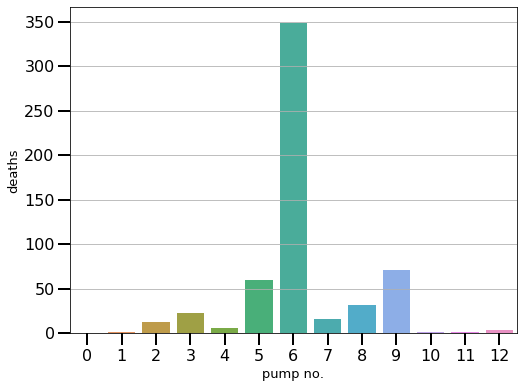

In [24]:
barplot_df = pd.DataFrame({"pump no.":np.arange(len(count_by_cell)), "deaths":count_by_cell})
plt.figure(figsize=[8,6])
sns.barplot(data = barplot_df, x = "pump no.", y = "deaths")

Both the map with the Voronoi cells and the barplot obviously suggests that the most contaminated pump was number 6. There is also a significant number of infection related death in the area of pump no. 5 and 9. Still important to note that at pump 2, 3, 7 and 8 there are less causalities.

## Exercise 6

Create a death density map using 2D Kernel Density Estimation. Display the density and its contours on the map along with the pumps. What is the density value at each of the pumps? Pinpoint the possible source of the infection.

*Use the projected Cartesian coordinate system for this exercise.* 

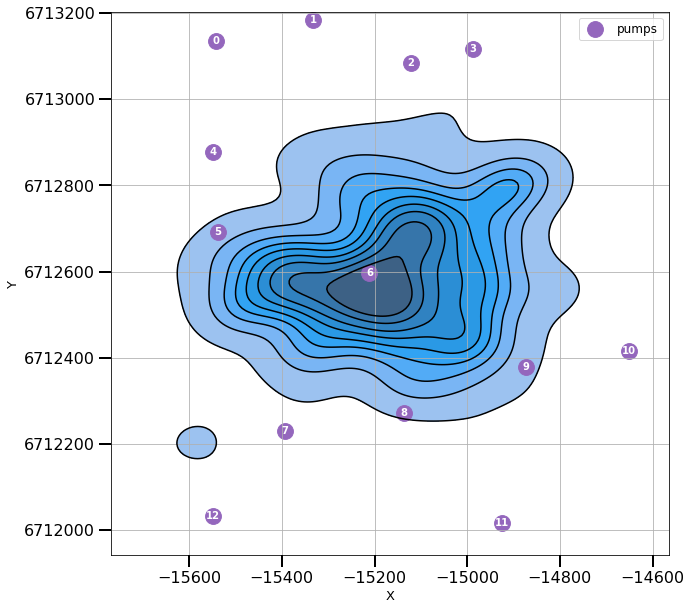

In [25]:
#Plotting the KDE on cartesian coordinates
plt.figure(figsize=[10,10])
sns.kdeplot(data = death_data[["X","Y"]], x ="X", y="Y", fill = True)
sns.kdeplot(data = death_data[["X","Y"]], x ="X", y="Y", color="black")
plt.scatter(pump_data.X,pump_data.Y,s=250,color="tab:purple", label="pumps" )
for idx in pump_data.index:
    plt.text(pump_data.iloc[idx].X, pump_data.iloc[idx].Y, str(idx), ha = "center", va="center", 
             color="white", weight ="bold")
    
plt.legend(fontsize=12)

Now this should be added to the Folium map.

In [26]:
#Extracting line data from the seaborn plot

polys = []
my_kde = sns.kdeplot(data = death_data[["X","Y"]], x ="X", y="Y")
for i in range(len(my_kde.collections)-1):
    #This is a contours polygonal representation
    v = my_kde.collections[i].get_paths()[0].vertices 
    x = v[:,0]
    y = v[:,1]
    
    polys.append( shapely.geometry.Polygon([(i[0], i[1]) for i in zip(x,y)]) ) 
    #Casting the coordinates into a shapely Polygon object
plt.clf()

<Figure size 432x288 with 0 Axes>

In [27]:
#Putting the extracted data into a gDF, reprojecting to WGS 84
shp_poly = gp.GeoDataFrame(polys, crs={"init":"EPSG:3857"}, columns = ["geometry"]).to_crs({'init':'epsg:4326'})
shp_poly

/home/dvtulf/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,geometry
0,"POLYGON ((-0.14008 51.51089, -0.14002 51.51089..."
1,"POLYGON ((-0.13568 51.51168, -0.13562 51.51167..."
2,"POLYGON ((-0.13578 51.51191, -0.13573 51.51191..."
3,"POLYGON ((-0.13557 51.51213, -0.13551 51.51212..."
4,"POLYGON ((-0.13530 51.51227, -0.13524 51.51227..."
5,"POLYGON ((-0.13622 51.51245, -0.13617 51.51245..."
6,"POLYGON ((-0.13655 51.51256, -0.13649 51.51255..."
7,"POLYGON ((-0.13660 51.51266, -0.13655 51.51265..."
8,"POLYGON ((-0.13671 51.51276, -0.13665 51.51275..."


In [28]:
#Here I tried to color each polygon one by one
'''fills = ["#9CC2F0","#79B5F4", "#52ABF6", "#31A3F3", "#2A99E5", "#2B8ED5", "#3082C1", "#3675AA", "#3675AA"]
geojsons = [ json.loads(gp.GeoDataFrame(shp_poly.iloc[i], crs = {'init':'epsg:4326'}).T.to_json()) 
            for i in range(len(shp_poly))]
mymap = folium.Map(location=[51.513,-0.135], zoom_start=15.5,tiles='cartodbpositron')
for i in range(9):
    folium.GeoJson(geojsons[i], style_function=lambda x:{ "color": fills[i]}).add_to(mymap)
mymap'''


'fills = ["#9CC2F0","#79B5F4", "#52ABF6", "#31A3F3", "#2A99E5", "#2B8ED5", "#3082C1", "#3675AA", "#3675AA"]\ngeojsons = [ json.loads(gp.GeoDataFrame(shp_poly.iloc[i], crs = {\'init\':\'epsg:4326\'}).T.to_json()) \n            for i in range(len(shp_poly))]\nmymap = folium.Map(location=[51.513,-0.135], zoom_start=15.5,tiles=\'cartodbpositron\')\nfor i in range(9):\n    folium.GeoJson(geojsons[i], style_function=lambda x:{ "color": fills[i]}).add_to(mymap)\nmymap'

In [29]:
#Visualizing the contours on the Folium map along with the pumps locations
mymap2 = folium.Map(location=[51.513,-0.135], zoom_start=15.4,tiles='cartodbpositron')
r_geojson2 = json.loads(shp_poly.to_json())
mymap2 = addPumpMarker(mymap2)
folium.GeoJson(r_geojson2).add_to(mymap2)
mymap2 #Sadly, I couldnt plot the outmost contour.


### Summary
Firstly, I took a good look at the KDE by using the Seaborn implementation.
Then the contour data of the KDE was extracted and cast into Shapely polygon objects. The polygon objects were collected in a Geopandas GDF to have them reprojected into WGS 84. I converted the proper projection into JSON which was put onto the Folium map.

On this map, we can see that again, that the infection's epicentre was at pump no. 6.

## Exercise 7

Create a GeoJSON object from the Voronoi cells, put the cells on the map, colored according to the number of deaths (like on a heatmap). Display the results in the notebook.

*[GeoJSON](http://geojson.org/) is a common format that is used in web applications. It is basically a simple key-value dictionary with a predefined structure for storing geographic information. Once loaded into Python, it behaves like a normal Python dictionary, thus creating or modifying it is quite straightforward. When reading or writing to a file, the `json` module is handy. The advice is to write a function that converts a list of coordinates from a polygon into a GeoJSON feature, then add it to your GeoJSON structure.*

In [30]:
geojsons3[0]

{'type': 'FeatureCollection',
 'features': [{'id': '0',
   'type': 'Feature',
   'properties': {},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-0.13834398060827974, 51.51556935039532],
      [-0.13947678850124068, 51.51853433292029],
      [-0.15418312653304994, 51.52312245422482],
      [-0.1433049709888945, 51.51562819001677],
      [-0.13834398060827974, 51.51556935039532]]]}}]}

In [31]:
import matplotlib
from matplotlib import cm

#norm = plt.Normalize()
norm = matplotlib.colors.LogNorm()
colors = cm.spring(norm(count_by_cell))
hex_colors = [matplotlib.colors.to_hex(x, keep_alpha=False) for x in colors]
#hex_colors = ["red"] * 12 + ["green"]

mymap4 = folium.Map(location=[51.513,-0.135], zoom_start=15.2,tiles='cartodbpositron')

#For some VERY VERY odd reason, this doesnt work, so I have to hardcode this part.
#The style function seems like to take a value only at "compile time"
#(although as far as I know, there is no such thing in python)
'''for i in range(len(geojsons3)):
    folium.GeoJson(geojsons3[i], style_function = lambda x: {"color" : hex_colors[i], "fillColor": hex_colors[i]},
                   tooltip = f"area of pump no. {i} | {count_by_cell[i]} deaths" ).add_to(mymap4)'''

#This doesnt work either
styles = [lambda x: {"color" : hex_colors[i], "fillColor": hex_colors[i]} for i in range(len(geojsons3))]


#So I had to write them one-by-one
folium.GeoJson(geojsons3[0], style_function = lambda x: {"color" : hex_colors[0], "fillColor": hex_colors[0]},
                   tooltip = f"area of pump no. {0} | {count_by_cell[0]} deaths" ).add_to(mymap4)

folium.GeoJson(geojsons3[1], style_function = lambda x: {"color" : hex_colors[1], "fillColor": hex_colors[1]},
                   tooltip = f"area of pump no. {1} | {count_by_cell[1]} deaths" ).add_to(mymap4)

folium.GeoJson(geojsons3[2], style_function = lambda x: {"color" : hex_colors[2], "fillColor": hex_colors[2]},
                   tooltip = f"area of pump no. {2} | {count_by_cell[2]} deaths" ).add_to(mymap4)

folium.GeoJson(geojsons3[3], style_function = lambda x: {"color" : hex_colors[3], "fillColor": hex_colors[3]},
                   tooltip = f"area of pump no. {3} | {count_by_cell[3]} deaths" ).add_to(mymap4)

folium.GeoJson(geojsons3[4], style_function = lambda x: {"color" : hex_colors[4], "fillColor": hex_colors[4]},
                   tooltip = f"area of pump no. {4} | {count_by_cell[4]} deaths" ).add_to(mymap4)

folium.GeoJson(geojsons3[5], style_function = lambda x: {"color" : hex_colors[5], "fillColor": hex_colors[5]},
                   tooltip = f"area of pump no. {5} | {count_by_cell[5]} deaths" ).add_to(mymap4)

folium.GeoJson(geojsons3[6], style_function = lambda x: {"color" : hex_colors[6], "fillColor": hex_colors[6]},
                   tooltip = f"area of pump no. {6} | {count_by_cell[6]} deaths" ).add_to(mymap4)

folium.GeoJson(geojsons3[7], style_function = lambda x: {"color" : hex_colors[7], "fillColor": hex_colors[7]},
                   tooltip = f"area of pump no. {7} | {count_by_cell[7]} deaths" ).add_to(mymap4)

folium.GeoJson(geojsons3[8], style_function = lambda x: {"color" : hex_colors[8], "fillColor": hex_colors[8]},
                   tooltip = f"area of pump no. {8} | {count_by_cell[8]} deaths" ).add_to(mymap4)

folium.GeoJson(geojsons3[9], style_function = lambda x: {"color" : hex_colors[9], "fillColor": hex_colors[9]},
                   tooltip = f"area of pump no. {9} | {count_by_cell[9]} deaths" ).add_to(mymap4)

folium.GeoJson(geojsons3[10], style_function = lambda x: {"color" : hex_colors[10], "fillColor": hex_colors[10]},
                   tooltip = f"area of pump no. {10} | {count_by_cell[10]} deaths" ).add_to(mymap4)

folium.GeoJson(geojsons3[11], style_function = lambda x: {"color" : hex_colors[11], "fillColor": hex_colors[11]},
                   tooltip = f"area of pump no. {11} | {count_by_cell[11]} deaths" ).add_to(mymap4)

folium.GeoJson(geojsons3[12], style_function = lambda x: {"color" : hex_colors[12], "fillColor": hex_colors[12]},
                   tooltip = f"area of pump no. {12} | {count_by_cell[12]} deaths" ).add_to(mymap4)

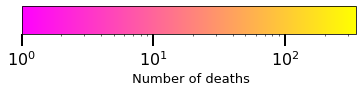

In [32]:
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.spring),
             cax=ax, orientation='horizontal', label=' Number of deaths')
#Scroll down to see colorbar
mymap4

In [33]:
id(styles[0]), id(styles[1]) #It looks like the lambdas are different objects, so that should've worked.
#I still dont get, why the for cycle doesnt work.

(139711464522072, 139711464522344)

## Exercise 8
(optional)
Download the street network of the area of the deaths from OpenStreetMap using its [map API](https://wiki.openstreetmap.org/wiki/API_v0.6#Retrieving_map_data_by_bounding_box:_GET_.2Fapi.2F0.6.2Fmap). Use street segments given back by the API as edges of a street graph. Develop a method based on the cholera dataset to classify these edges into three categories:
* existed at the time of John Snow
* did not exist at the time of John Snow
* cannot decide

*You'll get the id of each node and way that falls within a bounding box with the GET method of the map API. Use the ids to retrieve the shapes with the help of the ways API.*

*The results will be in XML format. Find a good [XML parser](https://docs.python.org/2/library/xml.etree.elementtree.html#module-xml.etree.ElementTree) to navigate the structures.*

## Exercise 9
(optional)

Plot the streets on the map along with the pumps and the deaths colored by the results of the classification.